# Baseline Code for ANLP

## Table of content:
0. [Getting Started](#1.-Getting-Started)


### 1 Getting started


In this notebook, you are going to be applying an BERT language model to the Microsoft Research Sentence Completion Challenge (Zweig and Burges, 2011).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 

drive  sample_data


In [ ]:
cd 'drive/MyDrive/UniSussex/Baseline_code_BERT'

/content/drive/MyDrive/UniSussex/Baseline_code_BERT


In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,random,math
import pickle
import operator
import re
import torch
import pickle

!pip install transformers

     |████████████████████████████████| 4.0 MB 35.8 MB/s 
     |████████████████████████████████| 6.6 MB 65.5 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 596 kB 76.8 MB/s 
     |████████████████████████████████| 895 kB 80.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###1.1 Creating class for the BERT language model

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

def get_training_testing(training_dir,split=0.5):
    '''
    Initially we have a 50% split from the data.
    '''
    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]
    return trainingfiles,heldoutfiles
    
class LanguageModel():
  '''
  Explain what this class is doing and can be broad
  '''
  def __init__(self, question_, answers_, choices_, langage_model_name,PATH):
    self.questions = question_
    self.answers = answers_
    self.choices = choices_
    self.model_name = langage_model_name
    self.model_path = PATH
    self.word_encodings = []
    self.sent_encodings = []
    self.mask_ix = []
    self.predicted_answers = []

  def model_evaluator(self):
    '''
    Have mode indept description of what each class is doing 
    '''
    print('The model running is',self.model_name)
    print('We have',len(self.questions),'questions')
    self.preprocessing()
    print('able to do preprocessing')
    if self.model_path == 'nada':
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
      self.model = AutoModelForMaskedLM.from_pretrained(self.model_name)
      print('here now')
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
      self.model = AutoModelForMaskedLM.from_pretrained(self.model_path)#, local_files_only=True)
      print('here was')

    print('model and tokenizer loaded')
    self.encodings()
    print('encoding has sucessfully completed')
    self.make_predictions()
    print('make predictions has finished running')
    self.get_model_accuracy()

  def preprocessing(self):
    choices_arr = np.array(choices) #to use np.where we need choices to be an numpy array
    answer_ids = []
    blank_space = '_____'
    questions_answerd = []
    questions_masked = []
    real_answers = []
    questions_withevery_answers = []
    
    for index, row in self.questions.iterrows():
      answer = self.answers.iloc[index][1]
      answer_ids.append(np.where(choices_arr == answer)[0][0])
      real_answers.append(row.loc[answer+')'])
      #in each question we have a),b), etc. While our list does not include the paratesis. Hence the reason for it's addition below. 
      questions_answerd.append(re.sub(blank_space, row.loc[answer+')'], row.loc['question']) )
      questions_masked.append(re.sub(blank_space, '<mask>', row.loc['question']))
      questions_withevery_answers.append([re.sub(blank_space, row.loc[choice+')'], row.loc['question']) for choice in choices])

    self.questions['questions_answerd'] = questions_answerd.copy()
    self.questions['question'] = questions_masked.copy()
    self.questions['real_answer'] = real_answers.copy()
    self.questions['replaced'] = questions_withevery_answers.copy()

  def encodings(self):
    #sent_encodings, word_encodings, mask_ix = [],[],[]
    for index, row in self.questions.iterrows():
      _sent_encoding, _word_encoding, _mask_ix = [],[],[]
      for i,(word,sent) in enumerate(zip(row[[choice+')' for choice in choices]], row.replaced)):
        #the spacing is to combat the issue that happens with our tokenizer. When the tokenizer goes over words that it 
        #does not have in it's vocabulary it will account as one and we should just add an extra speace in order to
        #avoid this issue as performed bellow
        encoded_word = self.tokenizer.encode(str(" " + word), add_special_tokens=False)
        #sending the tokens as pytorch tensors, also padding at max_length = 64. Passing attention as true since we want to have all the features in the sentence
        encoded_sent = self.tokenizer.encode_plus(sent,add_special_tokens=True,
                          return_tensors='pt', truncation=True,
                          padding='max_length', max_length=128,
                          return_attention_mask = True)
        word_token_len = len(encoded_word)
        possibles = np.where(np.array(encoded_sent['input_ids'][0]) == np.array(encoded_word)[0])[0]

        ix = 0
        for p in possibles:
            check = np.array(encoded_sent['input_ids'][0])[p:p+word_token_len]
            if np.all(check == encoded_word):
                ix = p    
        tokens_to_mask_ix = list(range(ix, (ix+word_token_len)))
        encoded_sent['input_ids'][0][tokens_to_mask_ix] = self.tokenizer.mask_token_id
        _sent_encoding.append(encoded_sent)
        _word_encoding.append(encoded_word)
        _mask_ix.append(tokens_to_mask_ix)

      self.word_encodings.append(_word_encoding)
      self.sent_encodings.append(_sent_encoding)
      self.mask_ix.append(_mask_ix)

  def make_predictions(self):   
    
    for index_1, (word_tokens,sent_encoding,mask_ix) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_ix)):
      print(f'Question {index_1}')
      scores = []
      #transform the predictions into tensors
      candidate_input_ids = torch.stack([sent['input_ids'].squeeze(0) for sent in sent_encoding])
      candidate_attention_masks = torch.stack([sent['attention_mask'].squeeze(0) for sent in sent_encoding])
      #add the tensors to the model
      candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits
      for idx, (token, mask_idxs) in enumerate(zip(word_tokens, mask_ix)):
        mask_token_logits = candidate_logits[idx, mask_idxs, token]
        predicted_score = float(torch.mean(mask_token_logits))
        scores.append(predicted_score)
      _predicted_answer = np.argmax(scores)
      #print(choices[_predicted_answer])
      self.predicted_answers.append(self.choices[_predicted_answer])

  def get_model_accuracy(self):
    correct = 0
    for prediction,answer in zip(self.predicted_answers, self.answers.answer):
      if prediction==answer:
        correct += 1
    score = correct/len(self.questions)
    print("Percentage of original predictions which are correct {:.5f}".format(score))
    return score

## 1.2 Now lets load in and have a look at the sentence completion challenge questions.

In [ ]:
#you may need to update this when running on your own machine 
parentdir= '../sentence-completion'
TRAINING_DIR=os.path.join(parentdir,"Holmes_Training_Data")
#training,testing=get_training_testing(TRAINING_DIR)

In [ ]:
import pandas as pd, csv
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

#read question plus questions and put in dataframe
with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])

with open(answers) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
as_df=pd.DataFrame(lines[1:],columns=lines[0])

In [ ]:
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [ ]:
choices=["a","b","c","d","e"]
question_test = qs_df.copy()
answers_test = as_df.copy()

In [ ]:

baseline_model_name = 'distilroberta-base'
evaluator = LanguageModel(question_test, answers_test, choices, baseline_model_name,'nada')
evaluator.model_evaluator()
#open a file, where you ant to store the data
# opening and dump information to file
res_BERT_dis = {"Sentence_Completiond_distilroberta-base":[evaluator.get_model_accuracy()]}
with open('Sentence_Completion_BERT-distilroberta-base_vanilla.pickle', 'wb') as f:
    pickle.dump(res_BERT_dis, f)

'\nbaseline_model_name = \'distilroberta-base\'\nevaluator = LanguageModel(question_test, answers_test, choices, baseline_model_name,\'nada\')\nevaluator.model_evaluator()\n#open a file, where you ant to store the data\n# opening and dump information to file\nres_BERT_dis = {"Sentence_Completiond_distilroberta-base":[evaluator.get_model_accuracy()]}\nwith open(\'Sentence_Completion_BERT-distilroberta-base_vanilla.pickle\', \'wb\') as f:\n    pickle.dump(res_BERT_dis, f)'

### 2 Training BERT with HOLMES corpus data: 

### 2.1 Load packages and pre process corpus data: 

In [ ]:
!pip install gutenberg
!pip install gutenberg-cleaner
!pip install datasets
nltk.download('punkt')
#https://github.com/kiasar/gutenberg_cleaner
#https://github.com/c-w/gutenberg

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from _cleaning_options.cleaner import super_cleaner, simple_cleaner
from transformers import DataCollatorForLanguageModeling
from transformers import AutoModelForMaskedLM
from transformers import Trainer, TrainingArguments
import datasets
from datasets import load_dataset, Dataset
import random

In [ ]:
files_clean_pure = []
files_clea_nopure = [] 
files_clean_pure_rest = []
training,testing=get_training_testing(TRAINING_DIR,split=1)
files = training

print("We will now preprocess {} different books".format(len(files)))
count=0
for index,afile in enumerate(files):
    lines = " "
    if index%100==0:
      print("Processing at index number {}".format(index))
    try:
        with open(os.path.join(TRAINING_DIR,afile)) as instream:
            for line in instream:
              lines+=(line)

            #connan doyle is the author of The adventures of sherlock holves in the gutemberg dataset
            if len(lines)>0 and re.search('conan doyle', lines, re.IGNORECASE):#use this if only training cherlock holmes books
            #if len(lines)>0 :#use when training with all the books
              files_clean_pure.append(simple_cleaner(lines).rstrip()) 
              count+=1 
            else:
              files_clean_pure_rest.append(simple_cleaner(lines).rstrip()) 
            files_clea_nopure.append(lines.rstrip())
    except UnicodeDecodeError:
        print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))

There are 522 files in the training directory: ../sentence-completion/Holmes_Training_Data
We will now preprocess 522 different books
Processing at index number 0
Processing at index number 100
UnicodeDecodeError processing WTSLW10.TXT: ignoring rest of file
UnicodeDecodeError processing MOHIC10.TXT: ignoring rest of file
Processing at index number 200
UnicodeDecodeError processing TBTAS10.TXT: ignoring rest of file
UnicodeDecodeError processing LLIFE10.TXT: ignoring rest of file
UnicodeDecodeError processing KRSON10.TXT: ignoring rest of file
Processing at index number 300
UnicodeDecodeError processing MFRND10.TXT: ignoring rest of file
UnicodeDecodeError processing TNGLW10.TXT: ignoring rest of file
UnicodeDecodeError processing HFDTR10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file
Processing at index number 400
UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing PHIL410.TXT: ignoring rest of fil

In [ ]:
extra_books_numb = 150
extra = random.sample(files_clean_pure_rest, extra_books_numb)
files_clean_pure.extend(extra)

In [ ]:
print("There are {} Conan Doyle books".format(count))
print(len(lines))
print(len(files_clean_pure))

There are 15 Conan Doyle books
285981
165


In [ ]:
'''
BERT models do not run with tokens largers than 512. For that reason there is the function group_texts which is responsible for 
dividing the tokens into chuncks that our model is able to run and return appropriate results
'''

# reference: https://finisky.github.io/finetunelmlinebyline.en/
def tokenize_function(examples):
    return tokenizer(examples["text"])

# Main data processing function that will concatenate all texts from our dataset and generate chunks of block_size.
def group_texts(examples):
  block_size = 512
  # Concatenate all texts.
  concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
  total_length = len(concatenated_examples[list(examples.keys())[0]])
	# We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
	# customize this part to your needs.
  if total_length >= block_size:
    total_length = (total_length // block_size) * block_size
	# Split by chunks of max_len.
  result = {
		k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
		for k, t in concatenated_examples.items()
	}
  result["labels"] = result["input_ids"].copy()
  return result

def training_model(PATH_file,model_name_train,learning_rate_=1e-6,
                   weight_decay_=0.01,num_train_epochs_=8,per_device_train_batch_size_=32,
                   mlm_probability_=0.15):
  print("We will now train using {} model".format(model_name_train))

  data = {'text':[texts for texts in files_clean_pure]}
  datasets = Dataset.from_dict(data)
  # split dataset into train/test
  datasets = datasets.train_test_split(test_size=0.1)

  tokenized_datasets = datasets.map(tokenize_function, batched=True, remove_columns=["text"])

  lm_datasets = tokenized_datasets.map(
      group_texts,
      batched=True,
      batch_size=1500,
      num_proc=4
  )

  data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
  trainer_model = AutoModelForMaskedLM.from_pretrained(model_name_train, return_dict=True)

  training_args = TrainingArguments(
      "test-mlm",
      evaluation_strategy = "epoch",
      learning_rate=learning_rate_,
      weight_decay=weight_decay_,
      num_train_epochs = num_train_epochs_,
      per_device_train_batch_size = per_device_train_batch_size_,
      save_steps=90000000
  )

  trainer = Trainer(
      model=trainer_model,
      args=training_args,
      train_dataset=lm_datasets["train"],
      eval_dataset=lm_datasets["test"],
      data_collator=data_collator,
  )

  trainer.train()
  trainer.save_model(PATH_file)

  max_eval_samples = len(lm_datasets['train'])

  metrics = trainer.evaluate()
  max_eval_samples = len(lm_datasets['train'])
  metrics["eval_samples"] = min(max_eval_samples, len(lm_datasets["test"]))
  try:
      perplexity = math.exp(metrics["eval_loss"])
  except OverflowError:
      perplexity = float("inf")
  metrics["perplexity"] = perplexity

  trainer.log_metrics("eval", metrics)
  trainer.save_metrics("eval", metrics)

  res_BERT_train = {"Sentence_Completiond_"+model_name_train+"-metrics-ttrained":metrics}
  with open(PATH_file+'/Sentence_Completion_BERT-'+model_name_train+'-metrics-trained.pickle', 'wb') as f:
    pickle.dump(res_BERT_train, f)


### 2.2 Training Baseline BERT with cleaned data 

In [ ]:
!nvidia-smi

Tue Apr 26 13:37:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    37W / 250W |  12709MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#it's always best to empty your cuda cache specially for large models
#https://stackoverflow.com/questions/68271605/how-to-fix-pytorch-runtimeerror-cuda-error-out-of-memory
#https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
import gc
import torch
gc.collect()

torch.cuda.empty_cache()

In [ ]:
'''
The path file is the name of the path where you want to save your model.
The model name is the model you want to re train
'''
PATH_file_1 = 'roberta-base_165'

model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
training_model(PATH_file=PATH_file_1,model_name_train=model_name,per_device_train_batch_size_=60,num_train_epochs_=15)

##3. Testing trained models

In [ ]:
'''
The model name of the model is the model we want to evaluate
The same name is the name we want to give to the pickle file that will be saved on our google drive
The path to file location of the model you trained in the previous section or you wish to evaluate
'''
model_name = 'roberta-base'

save_name_1 = 'roberta_distil0_50'

PATH_file_1 = 'roberta_distil0_50'

#https://stackoverflow.com/questions/64001128/load-a-pre-trained-model-from-disk-with-huggingface-transformers
question_test = qs_df.copy()
answers_test = as_df.copy()
evaluator_1 = LanguageModel(question_test, answers_test, choices, model_name,PATH_file_1)
evaluator_1.model_evaluator()
res_BERT_roberta_base = {"Sentence_Completiond_"+save_name_1+"-trained-tested":[evaluator_1.get_model_accuracy()]}
with open('Sentence_Completion_BERT-'+save_name_1+'-trained-tested.pickle', 'wb') as f:
    pickle.dump(res_BERT_roberta_base, f)

In [ ]:
model_name = 'distilroberta-base'

save_name_2 = 'roberta_distil_500'

PATH_file_2 = 'roberta_distil0_500'

question_test = qs_df.copy()
answers_test = as_df.copy()
evaluator_2= LanguageModel(question_test, answers_test, choices, model_name,PATH_file_2)
evaluator_2.model_evaluator()
res_BERT_roberta_base = {"Sentence_Completiond_"+save_name_2+"-trained-tested":[evaluator_2.get_model_accuracy()]}
with open('Sentence_Completion_BERT-'+save_name_2+'-trained-tested.pickle', 'wb') as f:
    pickle.dump(res_BERT_roberta_base, f)

The model running is distilroberta-base
We have 1040 questions


Could not locate the tokenizer configuration file, will try to use the model config instead.


able to do preprocessing


https://huggingface.co/distilroberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpmj4vjjj_


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

storing https://huggingface.co/distilroberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
creating metadata file for /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
loading configuration file https://huggingface.co/distilroberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/42d6b7c87cbac84fcdf35aa69504a5ccfca878fcee2a1a9b9ff7a3d1297f9094.aa95727ac70adfa1aaf5c88bea30a4f5e50869c68e68bce96ef1ec41b5facf46
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/distilroberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/23e0f7484fc8a320856b168861166b48c2976bb4e0861602422e1b0c3fe5bf61.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/23e0f7484fc8a320856b168861166b48c2976bb4e0861602422e1b0c3fe5bf61.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/distilroberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdk59x2el


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/distilroberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/c7e8020011da613ff5a9175ddad64cd47238a9525db975eb50ecb965e9f7302f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/c7e8020011da613ff5a9175ddad64cd47238a9525db975eb50ecb965e9f7302f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/distilroberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpy29gk3v4


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/distilroberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/b6a9ca6504e67903474c3fdf82ba249882406e61c2176a9d4dc9c3691c663767.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/b6a9ca6504e67903474c3fdf82ba249882406e61c2176a9d4dc9c3691c663767.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/distilroberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/23e0f7484fc8a320856b168861166b48c2976bb4e0861602422e1b0c3fe5bf61.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/distilroberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/c7e8020011da613ff5a9175ddad64cd47238a9525db975eb50ecb965e9f7302f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://hugg

here was
model and tokenizer loaded
encoding has sucessfully completed
Question 0
Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22
Question 23
Question 24
Question 25
Question 26
Question 27
Question 28
Question 29
Question 30
Question 31
Question 32
Question 33
Question 34
Question 35
Question 36
Question 37
Question 38
Question 39
Question 40
Question 41
Question 42
Question 43
Question 44
Question 45
Question 46
Question 47
Question 48
Question 49
Question 50
Question 51
Question 52
Question 53
Question 54
Question 55
Question 56
Question 57
Question 58
Question 59
Question 60
Question 61
Question 62
Question 63
Question 64
Question 65
Question 66
Question 67
Question 68
Question 69
Question 70
Question 71
Question 72
Question 73
Question 74
Question 75
Question 76
Question 77
Que

##4. Ploting results from models

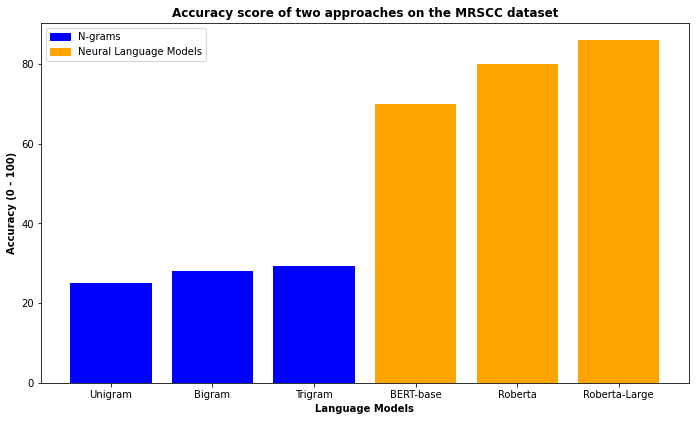

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

t_patch = mpatches.Patch(color='blue', label='N-grams')
o_patch = mpatches.Patch(color='orange', label='Neural Language Models')


fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0,0,1,1])
models = ['Unigram', 'Bigram', 'Trigram', 'BERT-base', 'Roberta','Roberta-Large']
scores = [25,28.1,29.4,70,80,86]
colors = ["orange" if i > 30 else "blue" for i in scores]
ax.bar(models,scores,color=colors)
ax.set_title("Accuracy score of two approaches on the MRSCC dataset",weight="bold")
ax.set_xlabel('Language Models',weight="bold")
ax.set_ylabel('Accuracy (0 - 100)',weight="bold")
# annotate
ax.legend(handles=[t_patch, o_patch])
plt.show()

In [ ]:
t_patch = mpatches.Patch(color='blue', label='N-grams')
o_patch = mpatches.Patch(color='orange', label='Neural Language Models')


fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0,0,1,1])
models = ['Unigram', 'Bigram', 'Trigram', 'BERT-base', 'Roberta','Roberta-Large']
scores = [25,28.1,29.4,70,80,86]
colors = ["orange" if i > 30 else "blue" for i in scores]
ax.bar(models,scores,color=colors)
ax.set_title("Accuracy score of two approaches on the MRSCC dataset",weight="bold")
ax.set_xlabel('Language Models',weight="bold")
ax.set_ylabel('Accuracy (0 - 100)',weight="bold")
# annotate
ax.legend(handles=[t_patch, o_patch])
plt.show()